# K-flip local search for MAX-SAT


+ This mini project has been prepared in conjunction with **[Prof. Stefan Szeider](http://szeider.net/)**



## Introduction


The paper "The parameterized complexity of k-flip local search for SAT and MAX SAT” (Stefan Szeider, Discrete Optimization 2011) provides a complexity theoretic analysis of a local search algorithm for the Boolean satisfiability problem, where at each step the truth value of up to k variables can be changed to increase the number of satisfied clauses. 

If k is large, it is theoretically hard to decide whether such a k-flip exists (the problem is called "k-Flip Max Sat” in the paper). In practice, however, one could use a CDCL SAT solver to accomplish this task. This would give rise to a "hybrid approach" that combines local search with a complete method.

For the SAT formulation of the k-Flip Max Sat problem one could use a sequential counter to encode that the number of flipped variables is at most k. (see, e.g., "Towards an Optimal CNF Encoding of Boolean Cardinality Constraints”, Carsten Sinz, CP 2005).

## Implementation

### Imports and Parameters
Some common libraries in python such as numpy for managing data, random for generating randomness, datetime for calculating the time spent in functions, and matplotlib for drawing plots have been used in this program.

Also, [pysat](https://github.com/pysathq/pysat) have been used to aim at providing a simple and unified interface to a number of Boolean satisfiability (SAT) solvers like Glucose and Lingeling as well as to a number of cardinality encodings:

+ **CNF library** to manage cnf formulas
+ **Glucose4 library** as a solver for cnf formulas
+ **CardEnc library** to apply different cardinality encodings on formulas

We will explain all functions briefly in their sections.

In [1]:
from pysat.formula import CNF
from pysat.solvers import Glucose4
from pysat.card import *
import numpy as np
import matplotlib.pyplot as plt
import random
from numpy import genfromtxt
import datetime
import matplotlib as mpl

### Compute satisfied clauses

These functions compute the number of satisfied clauses regarding one point. We will use these functions to evaluate the obtained assignments in the main loop.

The **satisfied clauses** are ones which have at least one literal with the sign that appears in the assignment.

+ *satisfied_clauses function* is a generator function that returns clauses which have been satisfied by the point.
+ *satisfied_clauses_number function* simply returns the number of satisfied clauses

The test function, check whether the function returns true values for different test cases, for example in the fourth test case we have $(x_1 \vee x_2) \land (x_2 \vee x_3) \land (x_3 \vee x_4) \land (x_4)$ and the assignment $(x_1=0, x_2=0, x_3=1, x_4=0)$ which results in satisfying the second and the third clauses.

[TODO] Add more test cases.

In [2]:
def satisfied_clauses(clauses, point):
    for item in clauses:
        for lit in item:
            if(lit in point):
                yield item
                break

def satisfied_clauses_number(clauses, point):
    return len([cl for cl in satisfied_clauses(clauses,point)])

def _test_satisfied_clauses():
    test_cases = [
        {
            'clauses': [[1],[2],[3],[4]],
            'point': [-1,-2,-3,-4],
            'num': 0
        },
        {
            'clauses': [[1],[2],[3],[4]],
            'point': [1,2,3,4],
            'num': 4
        },
        {
            'clauses': [[1,2],[2,3],[3,4],[4]],
            'point': [1,2,3,4],
            'num': 4
        },
        {
            'clauses': [[1,2],[2,3],[3,4],[4]],
            'point': [-1,-2,3,-4],
            'num': 2
        }
    ]
    for item in test_cases:
        if satisfied_clauses_number(item['clauses'], item['point']) != item['num']:
            raise ValueError('The random starting point is ordered.')
            
    print("[TEST SUCCESS] Satisfied clauses for a specific point is working correctly.")
    
_test_satisfied_clauses()

[TEST SUCCESS] Satisfied clauses for a specific point is working correctly.


### Starting point

This heuristic algorithm needs to select a point as a starting point. In the function below, we create the assignment with random signs in *random* method. It is possible to implement other methods if it is deemed necessary.

The test function, check the performance of the function with aspects of:

+ Size of the vector
+ Ranging from 1 to the size of the correct assignment

In [3]:
def starting_point(formula, method='random'):
    if(method == 'random'):
        nv = formula.nv
        init = [random.choice([p, -p]) for p in range(1, nv+1)]
        return init

def _test_starting_point():
    inp = CNF(from_file='samples/test.cnf')
    ret = starting_point(inp, 'random')

    if len(ret) != inp.nv :
        raise ValueError('The size of the random starting point is not correct.')
    for i, item in enumerate(ret):
        if i+1 != abs(item):
            raise ValueError('The random starting point is ordered.')
    print("[TEST SUCCESS] Starting point is working correctly.")

_test_starting_point()

[TEST SUCCESS] Starting point is working correctly.


### Sat relaxation formula

In order to change MAX-SAT to SAT formulas and then apply sat solver to them, an specific number of clauses must be able to relax. For this purpose, we can use a sequential counter.

According to the project, if $t$ clauses of $m$ are satisfied in the previous step ($n-t$ clauses are not satisfied), at most $n-t-1$ are able to not satisfied in the current step. In order to do it, we add fake variables to all clauses and at most $n-t-1$ of these variables can be set to TRUE using a sequential counter.

the *relaxation_formula* function gets three arguments *start*, *end*, and *ignorable_clauses* and returns a formula which at most *ignorable_clauses* number of their literals from *start* to *end* have to be TRUE.

The test function checks that the function works correctly.

In [4]:
def relaxation_formula(start, end, ignorable_clauses):
    return CardEnc.atmost(lits=range(start, end+1),
                           encoding=EncType.seqcounter, 
                           bound=ignorable_clauses)

def _test_relaxation():
    a , b , k = 5,10,4
    cnf = relaxation_formula(a, b, k)
    print("Formula", cnf.clauses)
    m = Glucose4(bootstrap_with=cnf.clauses)
    m.solve()
    size = [0]*10
    for item in m.enum_models():
        cnt = 0
        imp = item[a-1:b]
        for index in imp:
            if index > 0:
                cnt+=1
        
        size[cnt] = size[cnt]  +1
        
        if cnt > k:
            print(cnt, imp, satisfied_clauses_number(cnf.clauses, item))
            raise ValueError('The relaxation clauses is not working correctly!')
    print("LOG")
    for i, item in enumerate(size):
        print('# of true assignments of the formula which {} literal(s) ranging from {} and {} are TRUE ='.format(i, a, b),item)
    m.delete()
    print("[TEST SUCCESS] Clauses relaxation for a specific point is working correctly.")
_test_relaxation()

Formula [[11, -5], [-12], [-13], [-14], [-6, 15], [-11, 15], [-6, -11, 16], [-12, 16], [-6, -12, 17], [-13, 17], [-6, -13, 18], [-14, 18], [-6, -14], [-7, 19], [-15, 19], [-7, -15, 20], [-16, 20], [-7, -16, 21], [-17, 21], [-7, -17, 22], [-18, 22], [-7, -18], [-8, 23], [-19, 23], [-8, -19, 24], [-20, 24], [-8, -20, 25], [-21, 25], [-8, -21, 26], [-22, 26], [-8, -22], [-9, 27], [-23, 27], [-9, -23, 28], [-24, 28], [-9, -24, 29], [-25, 29], [-9, -25, 30], [-26, 30], [-9, -26], [-10, -30]]
LOG
# of true assignments of the formula which 0 literal(s) ranging from 5 and 10 are TRUE = 12000
# of true assignments of the formula which 1 literal(s) ranging from 5 and 10 are TRUE = 12240
# of true assignments of the formula which 2 literal(s) ranging from 5 and 10 are TRUE = 6080
# of true assignments of the formula which 3 literal(s) ranging from 5 and 10 are TRUE = 1760
# of true assignments of the formula which 4 literal(s) ranging from 5 and 10 are TRUE = 240
# of true assignments of the form

### K-flip formula

At each step, the truth value of up to k variables can be changed to increase the number of satisfied clauses. We control the number of changes using the sequential counter.

The *variable_limits_k* function gets three arguments of *instance*, *top_id*, and K and then returns a formula which at most K literals are different with the *instance*. It adds extra variables with id equal and more than *top_id*. The test function check the requirements of this function.

In [5]:
def variable_limits_k(instance, top_id, K):
    return CardEnc.atmost(lits=[-x for x in instance], 
                          encoding=EncType.seqcounter, 
                          top_id=top_id, 
                          bound=K)

def _test_variable_limits():
    K = 3
    top_id = 8
    top = 6
    instance = [random.choice([p, -p]) for p in range(1, top+1)]
    cnf = variable_limits_k(instance, top_id, K)
    print(cnf.clauses)
    
    size = [0]*100
    for item in cnf.clauses:
        for ind in item:
            if abs(ind) <= top_id and abs(ind) > top:
                raise ValueError('TOP ID parameter is not working!')
            
            size[abs(ind)] += size[abs(ind)] + 1

    m = Glucose4(bootstrap_with=cnf.clauses)
    m.solve()

    for item_dirty in m.enum_models():
        item = item_dirty[:len(instance)]
        diff1 = list(set(item) - set(instance))
        diff2 = list(set(instance) - set(item))
        
        if len(diff1) != len(diff2) or sorted(diff1) != sorted([-x for x in diff2]):
            raise ValueError('Instance and item are not equivalent!')
            
        if len(diff1) > K :
            raise ValueError('CNF does not control the limits correctly!')

    m.delete()
    
    print("[TEST SUCCESS] Items have less or equal K diff from the original Instance.")
    
_test_variable_limits()

[[9, 1], [-10], [-11], [2, 12], [-9, 12], [2, -9, 13], [-10, 13], [2, -10, 14], [-11, 14], [2, -11], [3, 15], [-12, 15], [3, -12, 16], [-13, 16], [3, -13, 17], [-14, 17], [3, -14], [-4, 18], [-15, 18], [-4, -15, 19], [-16, 19], [-4, -16, 20], [-17, 20], [-4, -17], [-5, 21], [-18, 21], [-5, -18, 22], [-19, 22], [-5, -19, 23], [-20, 23], [-5, -20], [6, -23]]
[TEST SUCCESS] Items have less or equal K diff from the original Instance.


### Generating sat formula in each step

In this step, we add two external clauses sets to control these requirements:

+ Improvements in results in each step. (Line 10-12)
+ The differences between assignments which should be less than and equal to K. (Line 14,15)

In [6]:
def k_flip_sat_formula(sat, instance, score, K):
    formula = sat.copy()
    bound = len(instance)
    instance_size = len(instance)
    
    for item in formula.clauses:
        bound = bound + 1
        item.append(bound)
        
    ignorable_clauses_number = len(sat.clauses) - score -1
    cnf_relaxation = relaxation_formula(instance_size+1, bound, ignorable_clauses_number)
    formula.extend(cnf_relaxation.clauses)
    
    k_flip_variables = variable_limits_k(instance, cnf_relaxation.nv, K)
    formula.extend(k_flip_variables.clauses)
    
    return formula

### Automated Test and print functions

Two first test functions apply in each step to make sure that we do things correctly. You can comment or uncomment relevant lines to control.

The print functions is used for checking.

In [7]:
def _test_k_flip(inst1, inst2 , K):
    cn = list(set(inst1) - set(inst2))
    nc = list(set(inst2) - set(inst1))
    if len(cn) <= K and len(nc) <= K :
        return True
    else:
        raise ValueError('K flip test failed!')
        return False

    
def _test_more_satisfied_clauses(sat, more, less):
    more_score = satisfied_clauses_number(sat.clauses, more)
    less_score = satisfied_clauses_number(sat.clauses, less)
    if more_score > less_score :
        return True
    else:
        print('- \[Failed\] MOre satisfied clauses test failed! {} and {}'.format(more_score, less_score))
        raise ValueError('More satisfied clauses test failed!')

        
def print_assignments_info(sat, assign):
    ns = satisfied_clauses_number(sat.clauses, assign)
    print('\n--Assignment-Info-------------------------------------------')
    print('- This assignment satisfies {} clauses from {}'.format(ns, len(sat.clauses)))
    print("- There are {} variables.".format(str(len(assign))))
    print('-----------------------------------------------------------\n')
    
    
def print_sat_information(formula):
    print('--DATASET-INFO--------------------------------------------')
    if sat.comments :
        for item in formula.comments:
            print(item)
    print("\n- There are {} variables.".format(str(formula.nv)))
    print("- There are {} clauses.".format(str(len(formula.clauses))))
    print("- The parameter K is {}.".format(K))
    print('-----------------------------------------------------------\n')

### Main algorithm

The main loop of the algorithm.

1. Start with a random assignment.
2. Create a customed SAT which ensures K-flip and improvements in the result.
3. Solve the SAT using Glucose4 method to give a new assignment.
4. Test the obtained assignment to ensure that everything works correctly. (only in testing)
5. Repeat the algorithm with the new assignment from step 3.

In [8]:
def k_flip_sat(sat, K):
    current_point = starting_point(sat)
    current_point_score = satisfied_clauses_number(sat.clauses,current_point)
    progress = True
    sat_size = len(sat.clauses)
    iteration_number = 0
    start_time = datetime.datetime.now()

#     print("\n- Steps:")
    while(progress):
        progress = False
        
#         print_assignments_info(sat, current_point)
        
        custom_cnf = k_flip_sat_formula(sat, current_point, current_point_score, K)
        
        m = Glucose4(bootstrap_with=custom_cnf.clauses)
        
        if m.solve():
            new_instance = m.get_model()[:len(current_point)]
            new_instance_score = satisfied_clauses_number(sat.clauses, new_instance)
            iteration_number = iteration_number + 1
        
            # TEST assumptions
            _test_k_flip(new_instance, current_point, K)
            _test_more_satisfied_clauses(sat, new_instance, current_point) 
                
            if new_instance_score < sat_size :
#                 print("- - A better answer with {} score by changing {} to {}."
#                       .format(new_instance_score, list(set(current_point) - set(new_instance)) ,list(set(new_instance) - set(current_point))))
                progress = True
            else:
                print("- - The best answer with {} score by changing {} to {}."
                      .format(new_instance_score, list(set(current_point) - set(new_instance)) ,list(set(new_instance) - set(current_point))))
                
            current_point, current_point_score = new_instance, new_instance_score
        else:
            "LOCAL MINIMUM"
        m.delete()
    
    seconds = (datetime.datetime.now() - start_time).total_seconds()
    print("+ The best result with {} score, {} iteration(s) in {} seconds for K={}.".format(current_point_score, iteration_number, seconds, K))
#     print(current_point)
    return {
        'score': current_point_score,
        'iteration_number': iteration_number,
        'time': seconds
    }
    return current_point_score

## Experiments
It can be changed to input*.cnf. Also, you can add your dataset to the samples folder or from [https://www.cs.ubc.ca/~hoos/SATLIB/benchm.html]. The result will be stored in 'output/[sample_name].out'.

The program accepts as input CNF formulas in DIMACS format because there is a large number of benchmark instances available in that format.

In [9]:
def make_result(sample_name, try_number, k_list ):
    sat = CNF(from_file='samples/{}'.format(sample_name))
    res = []
    file_name = 'output/' + sample_name + '.out'

    for item in range(try_number):
        temp = []
        for K in k_list:

            best_result = k_flip_sat(sat, K)

            with open(file_name, 'a') as file:
                file.write('{}, {}, {}, {}\n'.format(K,
                                                     best_result['score'], 
                                                     best_result['iteration_number'],
                                                     best_result['time']))

            temp.append(best_result['score'])

        res.append(temp)

# make_result('input2.cnf', 40, [10])

### Result

K	 #		 Score		 Iteration number		 time
1 | 	34 | 	412.1764705882353 | 	26.205882352941178 | 	6.414023323529412 | 	
2 | 	34 | 	416.4117647058824 | 	26.38235294117647 | 	5.575132147058823 | 	
3 | 	34 | 	418.0 | 	24.5 | 	5.226416588235295 | 	
4 | 	34 | 	419.05882352941177 | 	24.11764705882353 | 	5.107152823529412 | 	
5 | 	34 | 	419.6470588235294 | 	23.11764705882353 | 	6.998191823529411 | 	
6 | 	34 | 	420.6764705882353 | 	22.41176470588235 | 	6.591666735294118 | 	
7 | 	34 | 	420.61764705882354 | 	23.205882352941178 | 	12.035732794117648 | 	
8 | 	34 | 	420.7647058823529 | 	21.88235294117647 | 	23.35099205882353 | 	
9 | 	34 | 	420.9117647058824 | 	21.852941176470587 | 	33.70613820588235 | 	
10 | 	34 | 	421.3235294117647 | 	22.147058823529413 | 	73.31236685294118 | 	


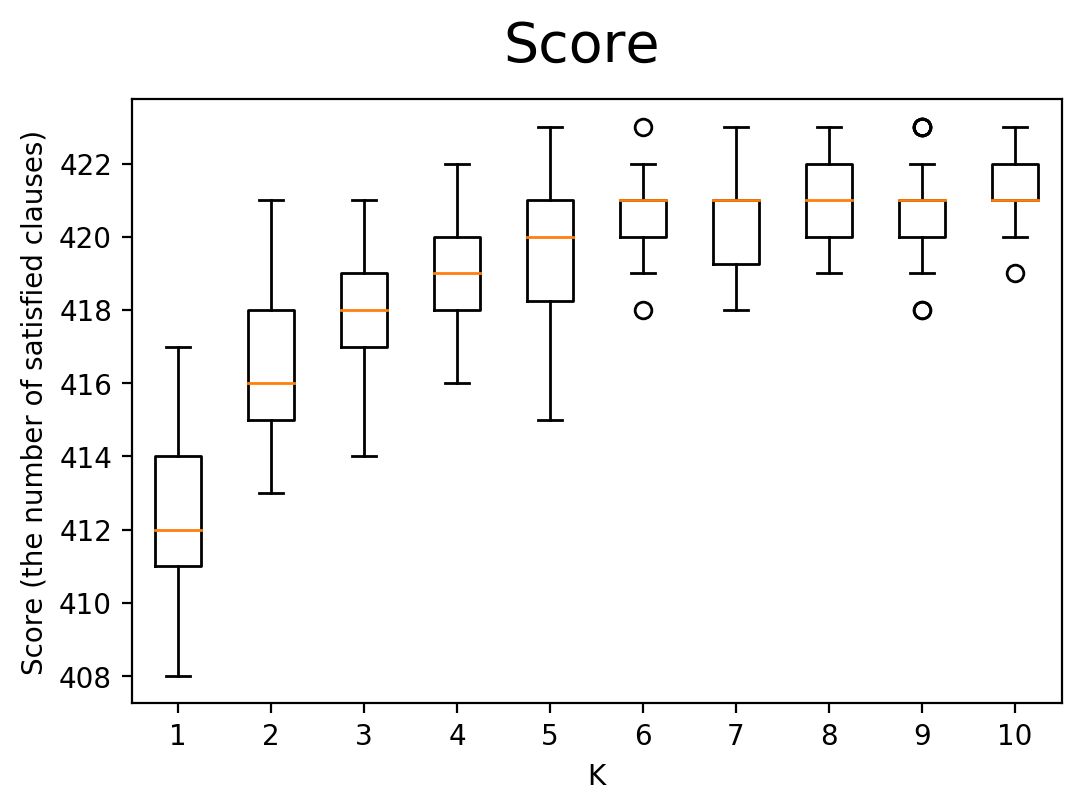

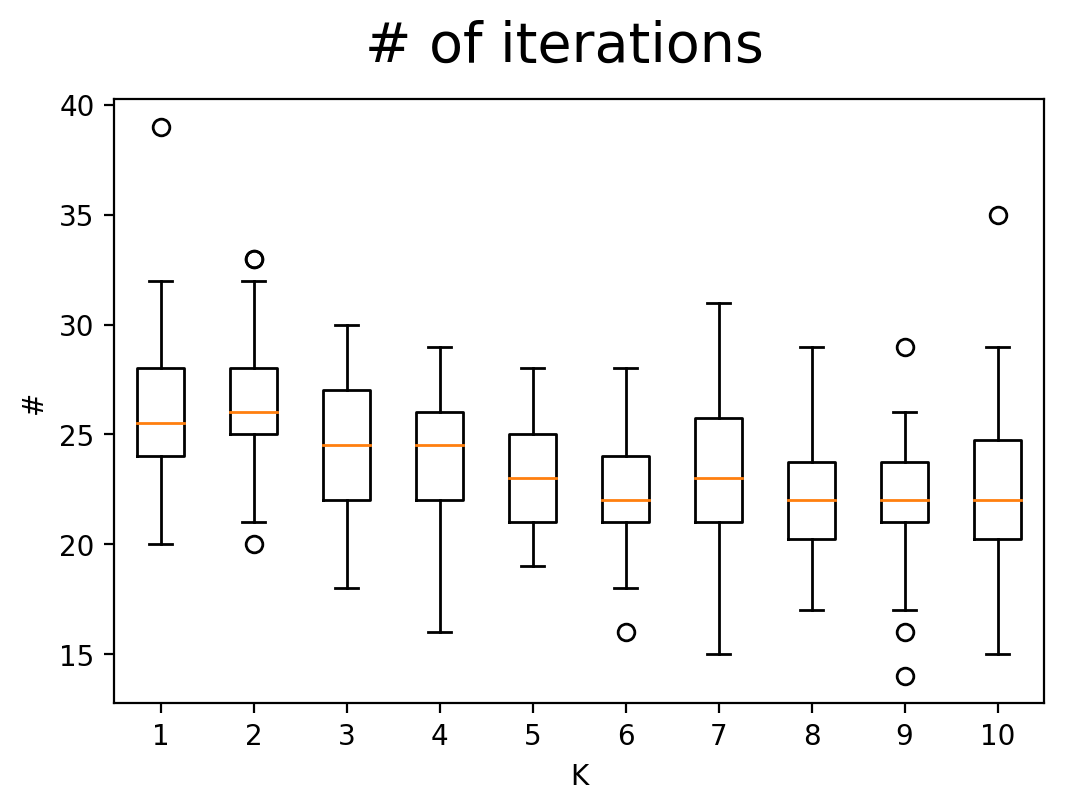

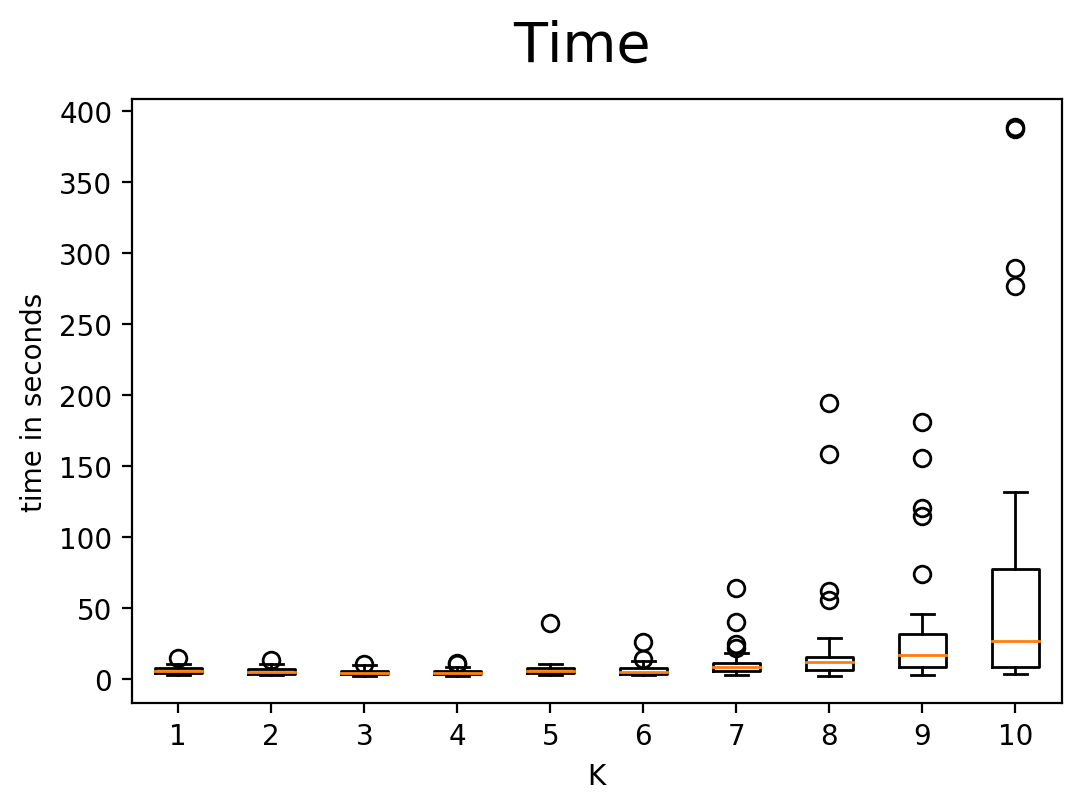

In [37]:
%matplotlib inline

mpl.rcParams['figure.dpi']= 200

def show_table(information, Max_K):
    
    data = [[
                              k+1,
                              len(information['score'][k]),
                              np.mean(information['score'][k]),
                              np.mean(information['iteration_number'][k]),
                              np.mean(information['time'][k])
                          ] for k in range(Max_K)]
    print('K\t', '#\t\t', 'Score\t\t','Iteration number\t\t', 'time')
    for item in data:
        for item2 in item:
            print(item2, end=' | \t')
        print()

def visualize_scores(information, Max_K):
    fig = plt.figure()
    ax = plt.boxplot(information['score'])
    
    fig.suptitle('Score', fontsize=20)
    plt.xlabel('K')
    plt.ylabel('Score (the number of satisfied clauses)')

def visualize_iteration_number(information, Max_K):
    fig = plt.figure()
    plt.boxplot(information['iteration_number'])
    
    fig.suptitle('# of iterations', fontsize=20)
    plt.xlabel('K')
    plt.ylabel('#')

def visualize_time(information, Max_K):
    fig = plt.figure()
    plt.boxplot(information['time'])
    
    fig.suptitle('Time', fontsize=20)
    plt.xlabel('K')
    plt.ylabel('time in seconds')

def exhibit_results(sample_name, Max_K):
    
    file_name = 'output/' + sample_name + '.out'
    content = genfromtxt(file_name, delimiter=',')

    information = {
        'score': [list() for _ in range(Max_K)],
        'iteration_number': [list() for _ in range(Max_K)],
        'time': [list() for _ in range(Max_K)]
    }
    
    for item_text in content:
        item_k = int(item_text[0])
        item_score = int(item_text[1])
        item_iteration_number = int(item_text[2])
        item_time = float(item_text[3])
        
        if item_k <= Max_K :
            information['score'][item_k-1].append(item_score)
            information['iteration_number'][item_k-1].append(item_iteration_number)
            information['time'][item_k-1].append(item_time)
            
#     pprint.pprint(information)
    show_table(information, Max_K)
    visualize_scores(information, Max_K)
    visualize_iteration_number(information, Max_K)
    visualize_time(information, Max_K)
    plt.show()
    
exhibit_results('input2.cnf', 10)